# LSTM

### 라이브러리

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style('whitegrid')
# plt.style.use("fivethirtyeight")
# %matplotlib inline

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import datetime
from sklearn.metrics import mean_squared_error

### 데이터 로드


*   pwd: 현재 경로 표시하기
*   cd drive/MyDrive/bigdata_project/data: 왼쪽 폴더 아이콘 누른 뒤 3번째 아이콘 눌러서 구글 드라이브를 마운트하고 다운 받은 엑셀파일이 저장된 경로를 찾아 들어가야함





In [ ]:
/pwd

'/content'

In [ ]:
cd drive/MyDrive/bigdata_project/data

/content/drive/MyDrive/bigdata_project/data


In [ ]:
ls

datareader_finbert_to_num_v2.xlsx
datareader_finbert_to_num.xlsx
datareader_finbert.xlsx
hyundai_stock_dataset_finBERT_notnull.xlsx
kakaobank_stock_dataset_finBERT_notnull.xlsx
naver_finance_news.xlsx
naver_news.xlsx
preprocessed_dup_eliminated_dataset_finBERT.xlsx
report.xlsx
samsung_stock_dataset_finBERT_notnull_select2.xlsx
samsung_stock_dataset_finBERT_notnull_select_column.xlsx
samsung_stock_dataset_finBERT_notnull.xlsx
stock_dataset_finBERT_notnull.xlsx


In [ ]:
# 로우 데이터로 엑셀파일 로드
# 실행 전에 미리 구글 드라이브 마운트를 해야하고 동일 경로에서 엑셀파일을 읽어들여야 함
raw_data = pd.read_excel('samsung_stock_dataset_finBERT_notnull.xlsx') # 삼성
# raw_data = pd.read_excel('hyundai_stock_dataset_finBERT_notnull.xlsx') # 현대

raw_data = raw_data.set_index("Date")
raw_data = raw_data.drop(['PSAR-up','PSAR-down'],axis=1)

print(raw_data.shape)
raw_data = raw_data.dropna(axis=0) # 널값 있는 행 제거
raw_data

(1234, 36)


,Open,High,Low,Close,Volume,Change,Rn,MRn,Volatility10,Volatility30,...,PSAR,RSI,ADX,OBV,OSCILLATOR,negative,neutral,positive,sentiment,Next_day
Date,,,,,,,,,,,,,,,,,,,,,
2018-11-22,42000,42650,42000,42450,5970796,0.008314,1.008314,0.990828,0.038202,0.082674,...,45051.520000,40.881416,18.101735,-13453907,-417.647059,0.030520,0.000077,0.969403,1,42400
2018-11-23,42450,42600,41900,42400,5192638,-0.001178,0.998822,0.996927,0.037061,0.079820,...,44921.459200,40.567862,17.555025,-18646545,-731.029412,0.101236,0.007946,0.890818,1,42600
2018-11-26,42150,42800,42100,42600,6613009,0.004717,1.004717,1.003951,0.028850,0.079954,...,44796.600832,42.468657,16.765372,-12033536,-944.852941,0.171952,0.015814,0.812233,1,43050
2018-11-27,42900,43100,42500,43050,8367091,0.010563,1.010563,1.004701,0.030665,0.080638,...,44676.736799,46.606462,15.616858,-3666445,-830.147059,0.046501,0.000300,0.953199,1,43150
2018-11-28,42800,43200,42750,43150,6943099,0.002323,1.002323,1.005868,0.030439,0.079615,...,44561.667327,47.509934,14.590579,3276654,-618.676471,0.762649,0.123316,0.114036,-1,43150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-02,66600,67000,66400,66700,14959443,-0.010386,0.989614,1.001076,0.033406,0.070579,...,68543.814928,47.724304,10.877366,640155380,-22.352941,0.000585,0.499241,0.500174,1,66800
2022-06-03,67200,67300,66800,66800,8222883,0.001499,1.001499,0.995561,0.032744,0.070580,...,68482.938629,48.344501,10.158162,648378263,148.529412,0.001084,0.998356,0.000561,0,65500
2022-06-07,66200,66400,65400,65500,19355755,-0.019461,0.980539,0.990551,0.035700,0.072899,...,68423.279857,41.458445,10.635226,629022508,47.941176,0.000039,0.000086,0.999876,1,65300


In [ ]:
# # 카카오뱅크

# # 로우 데이터로 엑셀파일 로드
# # 실행 전에 미리 구글 드라이브 마운트를 해야하고 동일 경로에서 엑셀파일을 읽어들여야 함
# raw_data = pd.read_excel('kakaobank_stock_dataset_finBERT_notnull.xlsx')

# raw_data = raw_data.set_index("Date")
# print(raw_data.shape)
# raw_data = raw_data.dropna(axis=0) # 널값 있는 행 제거
# raw_data

(205, 20)


,Open,High,Low,Close,Volume,Change,Rn,MRn,Volatility10,MA3,MA10,ATR,PSAR,RSI,OBV,negative,neutral,positive,sentiment,Next_day
Date,,,,,,,,,,,,,,,,,,,,
2021-08-26,83400,85300,82100,83400,4255489,0.015834,1.015834,0.976065,0.174742,83633.333333,84600.0,9035.714286,79427.154681,58.382125,92166711,0.970413,0.026522,0.003065,-1,83800
2021-08-27,82500,84400,82500,83800,2174014,0.004796,1.004796,0.993996,0.173728,83100.000000,85600.0,8526.020408,80624.982306,58.913134,94340725,0.000070,0.999882,0.000048,0,81900
2021-08-30,84000,84300,81600,81900,1782049,-0.022673,0.977327,0.999319,0.174607,83033.333333,86130.0,8109.876093,94400.000000,55.303579,92558676,0.000839,0.999052,0.000110,0,83900
2021-08-31,81000,83900,80900,83900,1768789,0.024420,1.024420,1.002181,0.118124,83200.000000,85780.0,7744.884944,94144.000000,58.206351,94327465,0.000186,0.999235,0.000579,0,88800
2021-09-01,83800,88900,82900,88800,6376407,0.058403,1.058403,1.020050,0.126321,84866.666667,86210.0,7620.250305,93614.240000,64.320184,100703872,0.000613,0.792303,0.207084,0,81900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-02,40300,40500,39800,39850,1117195,-0.019680,0.980320,0.988598,0.055249,40600.000000,40185.0,1234.158581,41750.000000,42.243899,29649018,0.004704,0.768766,0.226530,0,41150
2022-06-03,40300,41300,40150,41150,1406396,0.032622,1.032622,0.999068,0.057738,40550.000000,40435.0,1249.575825,41711.000000,49.614437,31055414,0.002548,0.883931,0.113520,0,41500
2022-06-07,41100,41900,40700,41500,1678530,0.008505,1.008505,1.007149,0.050586,40833.333333,40590.0,1246.034695,39800.000000,51.412222,32733944,0.000393,0.999096,0.000511,0,40400


In [ ]:
raw_data.tail()

,Open,High,Low,Close,Volume,Change,Rn,MRn,Volatility10,MA3,MA10,ATR,PSAR,RSI,OBV,negative,neutral,positive,sentiment,Next_day
Date,,,,,,,,,,,,,,,,,,,,
2022-06-02,40300,40500,39800,39850,1117195,-0.019680,0.980320,0.988598,0.055249,40600.000000,40185.0,1234.158581,41750.0,42.243899,29649018,0.004704,0.768766,0.226530,0,41150
2022-06-03,40300,41300,40150,41150,1406396,0.032622,1.032622,0.999068,0.057738,40550.000000,40435.0,1249.575825,41711.0,49.614437,31055414,0.002548,0.883931,0.113520,0,41500
2022-06-07,41100,41900,40700,41500,1678530,0.008505,1.008505,1.007149,0.050586,40833.333333,40590.0,1246.034695,39800.0,51.412222,32733944,0.000393,0.999096,0.000511,0,40400
2022-06-08,41500,41500,39600,40400,2070212,-0.026506,0.973494,1.004874,0.058430,41016.666667,40630.0,1292.746502,41900.0,45.872439,30663732,0.000041,0.999912,0.000047,0,41050
2022-06-09,40200,42300,39950,41050,6994591,0.016089,1.016089,0.999363,0.057289,40983.333333,40795.0,1368.264609,39600.0,49.345780,37658323,0.000034,0.999905,0.000061,0,39150


### X, y 설정

             Open   High    Low  Close    Volume    Change        Rn  \
Date                                                                   
2018-11-22  42000  42650  42000  42450   5970796  0.008314  1.008314   
2018-11-23  42450  42600  41900  42400   5192638 -0.001178  0.998822   
2018-11-26  42150  42800  42100  42600   6613009  0.004717  1.004717   
2018-11-27  42900  43100  42500  43050   8367091  0.010563  1.010563   
2018-11-28  42800  43200  42750  43150   6943099  0.002323  1.002323   
...           ...    ...    ...    ...       ...       ...       ...   
2022-06-02  66600  67000  66400  66700  14959443 -0.010386  0.989614   
2022-06-03  67200  67300  66800  66800   8222883  0.001499  1.001499   
2022-06-07  66200  66400  65400  65500  19355755 -0.019461  0.980539   
2022-06-08  65400  65700  65300  65300  12483180 -0.003053  0.996947   
2022-06-09  65100  65200  64500  65200  25790725 -0.001531  0.998469   

                 MRn  Volatility10  Volatility30  ...         M

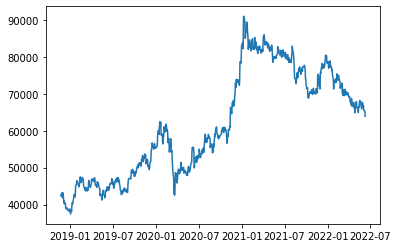

In [ ]:
raw_X_A = raw_data.iloc[:, :31] # finbert 결과만 추가했음
raw_y = raw_data.iloc[:, 35:36] # 다음날 종가 데이터가 들어있음

print(raw_X_A)
print(raw_y)

plt.plot(raw_y, label = 'samsung')
plt.show()

             Open   High    Low  Close   Volume    Change        Rn       MRn  \
Date                                                                            
2021-08-26  83400  85300  82100  83400  4255489  0.015834  1.015834  0.976065   
2021-08-27  82500  84400  82500  83800  2174014  0.004796  1.004796  0.993996   
2021-08-30  84000  84300  81600  81900  1782049 -0.022673  0.977327  0.999319   
2021-08-31  81000  83900  80900  83900  1768789  0.024420  1.024420  1.002181   
2021-09-01  83800  88900  82900  88800  6376407  0.058403  1.058403  1.020050   
...           ...    ...    ...    ...      ...       ...       ...       ...   
2022-06-02  40300  40500  39800  39850  1117195 -0.019680  0.980320  0.988598   
2022-06-03  40300  41300  40150  41150  1406396  0.032622  1.032622  0.999068   
2022-06-07  41100  41900  40700  41500  1678530  0.008505  1.008505  1.007149   
2022-06-08  41500  41500  39600  40400  2070212 -0.026506  0.973494  1.004874   
2022-06-09  40200  42300  39

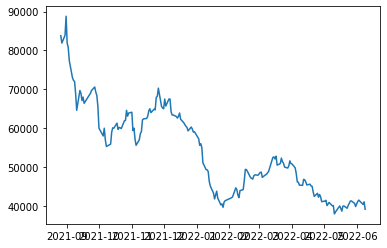

In [ ]:
# # 카카오뱅크
# raw_X_A = raw_data.iloc[:, :15] # finbert 결과만 추가했음
# raw_y = raw_data.iloc[:, 19:20] # 다음날 종가 데이터가 들어있음

# print(raw_X_A)
# print(raw_y)

# # plt.plot(raw_y, label = 'samsung')
# plt.plot(raw_y, label = 'kakao bank')
# plt.show()

### 전처리

In [ ]:
# X, y 데이터를 0~1 사이 값으로 정규화 
# 학습이 잘되기 위해 하는 것이고, 이 값은 추후 inverse로 도로 되돌림
sc = MinMaxScaler()
sc_X = sc.fit_transform(raw_X_A)
sc_y = sc.fit_transform(raw_y)

train_size = int(len(sc_y) * 0.67)
test_size = len(sc_y) - train_size

# 텐서화? 하기
dataX = Variable(torch.Tensor(np.array(sc_X)))
dataY = Variable(torch.Tensor(np.array(sc_y)))

# train 데이터 2/3으로 자르기
trainX = Variable(torch.Tensor(np.array(sc_X[0:train_size])))
trainY = Variable(torch.Tensor(np.array(sc_y[0:train_size])))

# test 데이터 나머지 1/3으로 자르기
testX = Variable(torch.Tensor(np.array(sc_X[train_size:len(sc_X)])))
testY = Variable(torch.Tensor(np.array(sc_y[train_size:len(sc_y)])))

print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

# lstm 모델에 적용할 때 shape을 변경해줘야 함 
# reshape(a, (b,1,c)) 형태로 모델에 돌리기 위해 2차원으로 바꿔주는 것임

trainX_fin = torch.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX_fin = torch.reshape(testX, (testX.shape[0], 1, testX.shape[1])) 

dataX_fin = torch.reshape(dataX, (dataX.shape[0], 1, dataX.shape[1]))
print("Training Shape", trainX_fin.shape, trainY.shape)
print("Testing Shape", testX_fin.shape, testY.shape) 
print(dataX_fin.shape, dataY.shape)

torch.Size([585, 31])
torch.Size([289, 31])
torch.Size([585, 1])
torch.Size([289, 1])
Training Shape torch.Size([585, 1, 31]) torch.Size([585, 1])
Testing Shape torch.Size([289, 1, 31]) torch.Size([289, 1])
torch.Size([874, 1, 31]) torch.Size([874, 1])


### 모델 정의

In [ ]:
# 모델 정의하기

class LSTM(nn.Module):
    # Long Short Term Memory
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.relu(h_out)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        
        return out


### 학습

In [ ]:
num_epochs = 20000
learning_rate = 0.0005

input_size = trainX_fin.shape[2] # 컬럼 개수
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, trainX_fin.shape[1])

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm.forward(trainX_fin)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = loss_function(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.09373
Epoch: 100, loss: 0.04191
Epoch: 200, loss: 0.03522
Epoch: 300, loss: 0.01760
Epoch: 400, loss: 0.00672
Epoch: 500, loss: 0.00468
Epoch: 600, loss: 0.00321
Epoch: 700, loss: 0.00234
Epoch: 800, loss: 0.00196
Epoch: 900, loss: 0.00182
Epoch: 1000, loss: 0.00175
Epoch: 1100, loss: 0.00169
Epoch: 1200, loss: 0.00164
Epoch: 1300, loss: 0.00159
Epoch: 1400, loss: 0.00154
Epoch: 1500, loss: 0.00150
Epoch: 1600, loss: 0.00147
Epoch: 1700, loss: 0.00143
Epoch: 1800, loss: 0.00140
Epoch: 1900, loss: 0.00137
Epoch: 2000, loss: 0.00135
Epoch: 2100, loss: 0.00133
Epoch: 2200, loss: 0.00132
Epoch: 2300, loss: 0.00130
Epoch: 2400, loss: 0.00129
Epoch: 2500, loss: 0.00128
Epoch: 2600, loss: 0.00127
Epoch: 2700, loss: 0.00126
Epoch: 2800, loss: 0.00126
Epoch: 2900, loss: 0.00125
Epoch: 3000, loss: 0.00124
Epoch: 3100, loss: 0.00123
Epoch: 3200, loss: 0.00123
Epoch: 3300, loss: 0.00122
Epoch: 3400, loss: 0.00121
Epoch: 3500, loss: 0.00121
Epoch: 3600, loss: 0.00120
Epoch: 3700, 

### 모델 평가

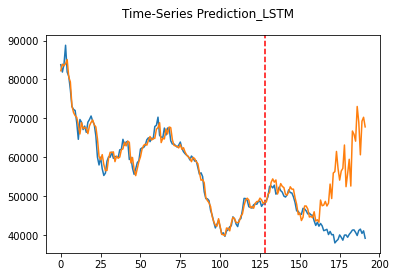

,True,Pred,close,direction,direc_pred
0,83800.0,82242.570312,83400,1,0
1,81900.0,83939.007812,83800,0,1
2,83900.0,83511.304688,81900,1,1
3,88800.0,84063.804688,83900,1,1
4,81900.0,85117.320312,88800,0,0
...,...,...,...,...,...
187,41150.0,68971.601562,39850,1,1
188,41500.0,60616.941406,41150,1,1
189,40400.0,69263.773438,41500,0,1
190,41050.0,70272.007812,40400,1,1


MSE : 58225888.0, RMSE : 7630.5888671875, SCORE : 56.2%


In [ ]:
# 모델 평가하기
lstm.eval()

# 학습시킨 모델에 전체 데이터를 적용시켜 Y를 추출한 것

# 전체 데이터의 2/3인 train 데이터까지는 모델 학습에서 사용했던 데이터이고
# 1/3인 test 데이터는 모델이 예측한 값
train_predict = lstm(dataX_fin)

# 전체 데이터 예측 값(Y)을 numpy array로 변경
data_predict = train_predict.data.numpy()

# 실제 Y데이터 값을 numpy array로 변경
dataY_plot = dataY.data.numpy()

# 위에서 모델에 적용하려고 0~1 사이로 정규화했던 값을 다시 inverse
data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

# 학습에 사용됐던 데이터와 예측한 값의 경계를 선으로 표현
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction_LSTM')
plt.show()

# 예측값: data_predict
# 실제값: dataY_plot

data_predict_fin = list(data_predict.flatten())
dataY_plot_fin = list(dataY_plot.flatten())

score_table = pd.DataFrame({'True': dataY_plot_fin,
                            'Pred': data_predict_fin})


# -----
score_table['close'] = list(raw_data['Close'])

# i[1][0] # True
# i[1][1] # Pred
# i[1][2] # close
# 1: up
# 0: down
# cnt: up&down 맞춘 갯수
# result: up&down 예측 정확도

direction = []
direc_pred = []
for i in score_table.iterrows():
    if i[1][0] >= i[1][2]:
        direction.append(1)
    else:
        direction.append(0)

for i in score_table.iterrows():
    if i[1][1] >= i[1][2]:
        direc_pred.append(1)
    else:
        direc_pred.append(0)

score_table['direction'] = direction
score_table['direc_pred'] = direc_pred

cnt = 0
for i in score_table.iterrows():
    if i[0] >= train_size:
        if i[1][3] == i[1][4]:
            cnt += 1

result = cnt/(len(score_table)-train_size)*100
result = result
# -----

display(score_table)

# validation score
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)

print(f"MSE : {MSE}, RMSE : {RMSE}, SCORE : {result:.1f}%")